In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Adding database path
database_path = "hawaii.sqlite"

In [6]:
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [14]:
# Exploring the database - station
Base.classes.station.__dict__ 

mappingproxy({'__table__': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.station'> at 1d19172e048>,
              '__init__': <function __init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x1d19172e288>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x1d19172e348>,
              'name': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x1d19172e408>,
              'latitude': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x1d19172e4c8

In [28]:
# Exploring the database - measurement
Base.classes.measurement.__dict__

mappingproxy({'__table__': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.measurement'> at 26e04509a68>,
              '__init__': <function __init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x26e04509b28>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x26e04509be8>,
              'date': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x26e04509ca8>,
              'prcp': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x26e04509d68>,
              'tobs': <sqlalc

# Exploratory Climate Analysis

2017-08-23
2016-08-23 00:00:00


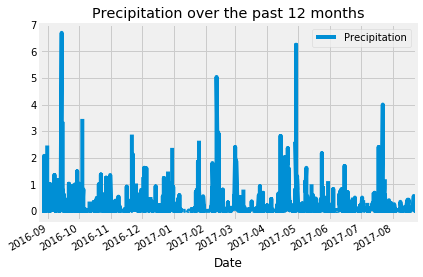

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0]

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.datetime.strptime(last_date,"%Y-%m-%d") - dt.timedelta(days=365)
print(last_date)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
data_precp_score = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >=one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(data_precp_score, columns=['Date','Precipitation'])
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format = '%Y-%m-%d')

# Setting the index
precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date', ascending=True)
precipitation_df

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Precipitation over the past 12 months")
plt.legend(loc='upper right')
plt.show()

In [49]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [50]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Measurement.station).distinct().count()
number_of_stations

9

In [72]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

# Finding the most active station
Most_active_station = str(most_active_stations[0][0])
Most_active_station

'USC00519281'

In [86]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
temps_recorded = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == Most_active_station).all()
temps_recorded                
# highest temperature recorded, and average temperature of the most active station?

# Printing the output message
print(f'The Minimum, Maximum and Average temperature of station {Most_active_station} is: {temps_recorded[0][0]}, {temps_recorded[0][1]},{temps_recorded[0][2]}')


The Minimum, Maximum and Average temperature of station USC00519281 is: 54.0, 85.0,71.66378066378067


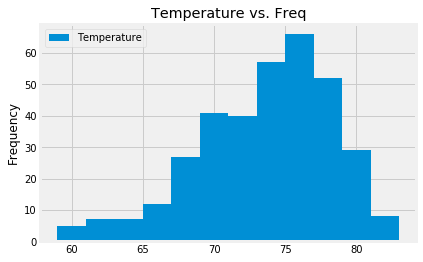

In [95]:
# Choose the station with the highest number of temperature observations.
most_station_temps = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_station_temps = most_station_temps[0]

most_station_temps

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago).filter(Measurement.station == most_station_temps).all()

#Creating a dataframe with the observations
temp_observations = pd.DataFrame(temp_observations, columns=['Temperature'])


#Plotting the results

temp_observations.plot.hist(bins=12,title="Temperature vs. Freq")
plt.show()

## Bonus Challenge Assignment

In [96]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
